### Model overview

In [ ]:
import pandas as pd
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from src.myscripts.model import Conv1DClassifier
import os
import numpy as np
from matplotlib import pyplot as plt
import config

In [3]:
model_history_path = config.MODEL_HISTORY_DIR_PATH

def plot_model_losses(model_name):
    val_losses = np.load(os.path.join(model_history_path, f"{model_name}_val_losses.npy"))
    train_losses = np.load(os.path.join(model_history_path, f"{model_name}_train_losses.npy"))
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"{model_name}'s loss over epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

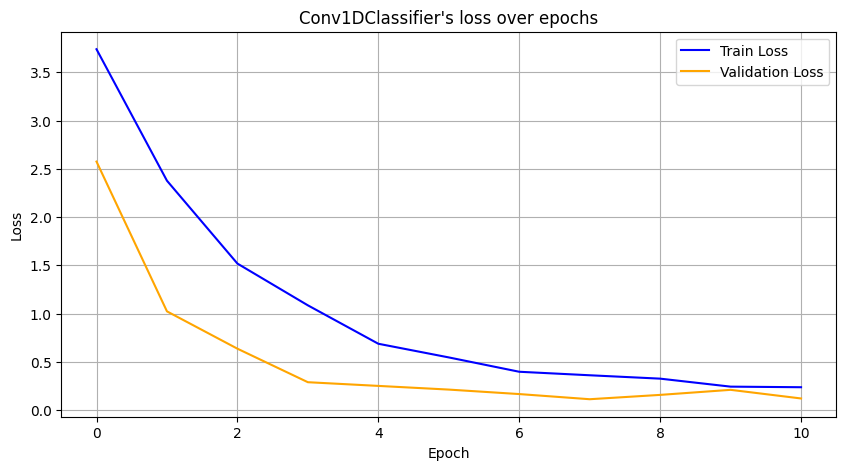

In [4]:
plot_model_losses("Conv1DClassifier")

Test Accuracy: 0.966


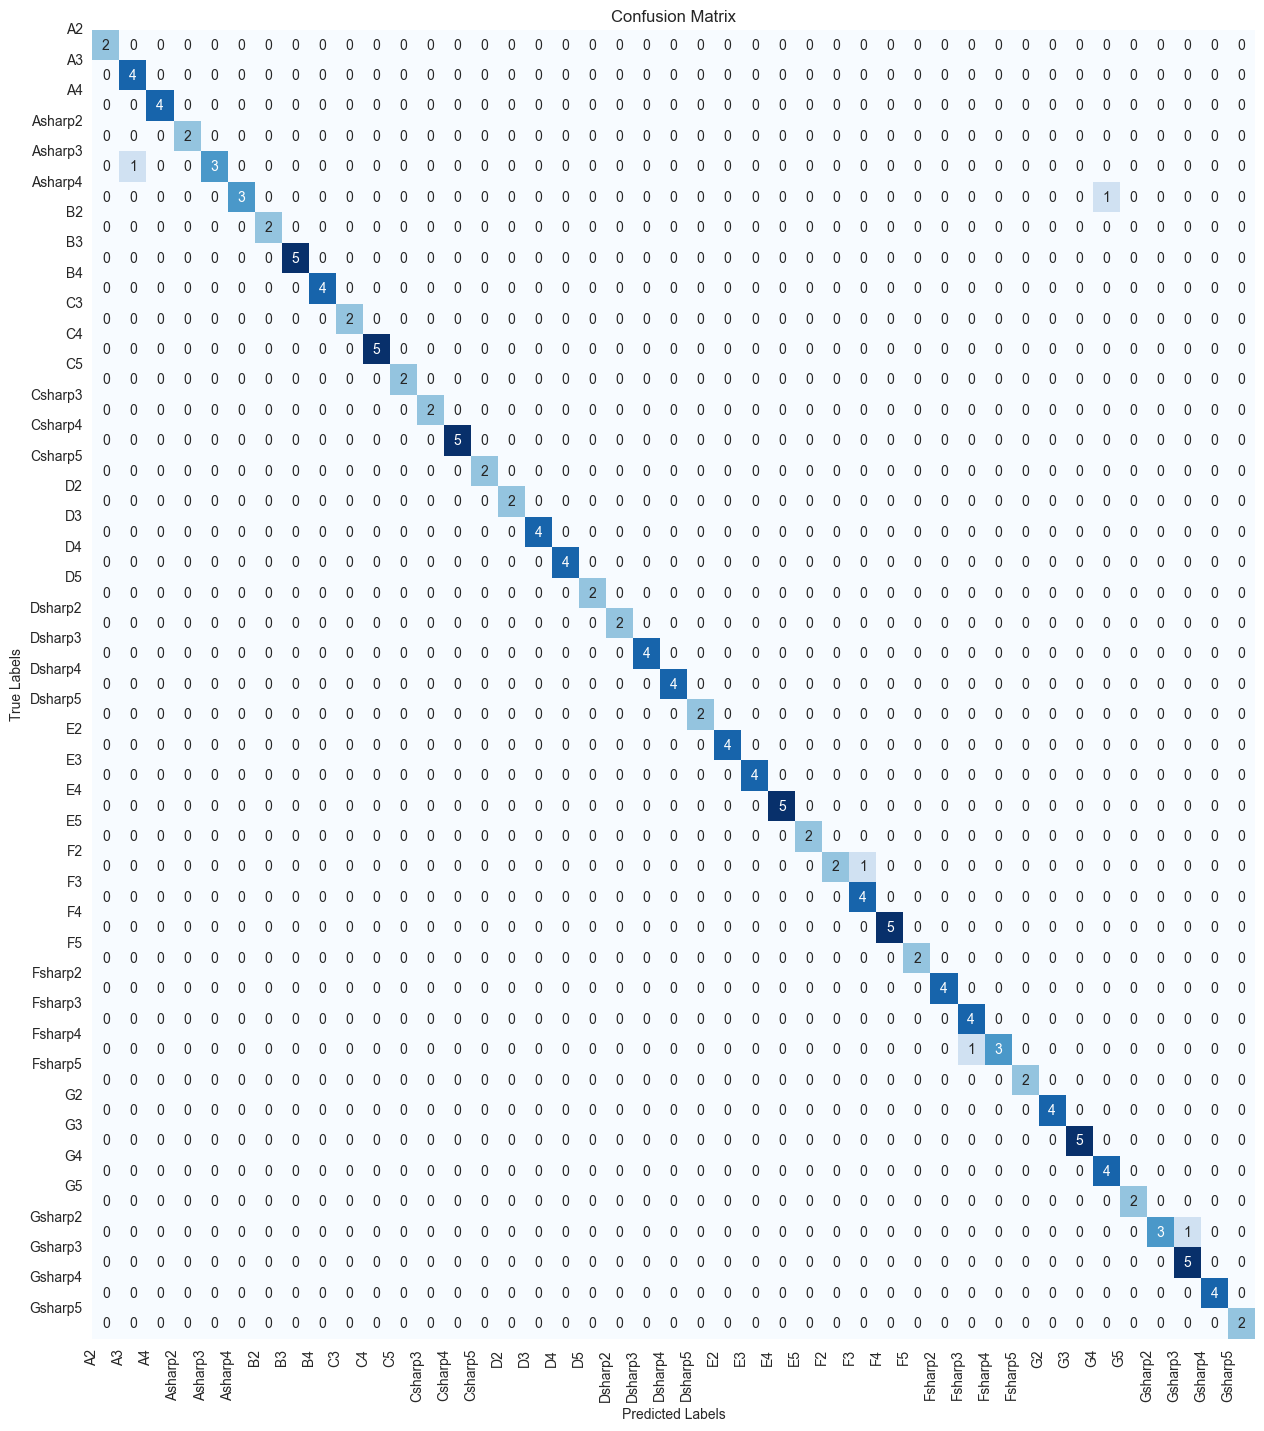

In [14]:
splits_path = config.DATA_SPLIT_SAVE_DIR_PATH
model_path  = config.MODEL_DIR_PATH
dataframes_path = config.DATAFRAMES_DIR_PATH
model_name = "Conv1DClassifier"
dataframe_file_name = "sound_data.csv"

x_test = np.load(os.path.join(splits_path, "x_test.npy"), allow_pickle=True)
y_test = np.load(os.path.join(splits_path, "y_test.npy"), allow_pickle=True)

x_test = x_test.astype(np.float32)
y_test = y_test.astype(np.long)

input_shape = x_test.shape[1:]
model = Conv1DClassifier(num_classes=43, input_shape=input_shape)
model.load_state_dict(torch.load(os.path.join(model_path, f"{model_name}.pth")))

#Przelaczenie modelu w tryb ewaluacji
model.eval()

x_test_tensor = torch.tensor(x_test).to("cpu")
with torch.no_grad():
    outputs = model(x_test_tensor)
    _, predictions = torch.max(outputs, 1)

predictions = predictions.cpu().numpy()

#Przekonwertowanie jezeli etykiety bylyby w One-hot
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    true_labels = np.argmax(y_test, axis=1)
else:
    true_labels = y_test

accuracy = accuracy_score(true_labels, predictions)
print(f'Test Accuracy: {accuracy:.3f}')

labels_to_map = np.unique(pd.read_csv(os.path.join(dataframes_path,f"{dataframe_file_name}")).iloc[:,-1])
conf_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(15, 17))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(len(labels_to_map)), labels=labels_to_map, rotation=90)
plt.yticks(ticks=np.arange(len(labels_to_map)), labels=labels_to_map, rotation=0)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()